# Dataset exploration
In the first part only basic stats

The notebook expects pre-created train, val, and test DataFrames stored in the pickle format in `data/old_datasets` and `data/new_datasets` folders. 

In [2]:
from typing import Tuple
import pandas as pd
import sys
sys.path.append("../") # go to parent dir

old_storage_folder = Path('../../data/old_datasets')
storage_folder = Path('../../data/new_datasets')

def load_datasets(storage_folder_) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return [pd.read_pickle(storage_folder_ / f'{phase}_beatmaps.pkl') for phase in
            ['train', 'val', 'test']]

In [3]:
from IPython.display import display, Markdown, Latex

def dataset_stats(df: pd.DataFrame):
    # 1/2 of snippets are overlapping
    group_over = ['name', 'difficulty', 'snippet', 'time', ]
    for end_index in range(1, len(group_over) + 1):
        print(f"{df.groupby(group_over[:end_index]).ngroups:9} unique {' × '.join(group_over[:end_index])}")
    
    print(f"{df.groupby(['name']).apply(lambda x: x.index.to_frame()['time'].max()).sum() / 3600:9.2f} "
          'hours of unique audio')
    print(f"{df.groupby(['name', 'difficulty']).apply(lambda x: x.index.to_frame()['time'].max()).sum() / 3600:9.2f} "
          'hours of unique gameplay')
    print(f"{len(df['word'].unique()):9} unique actions")

def whole_dataset_stats(train, val, test):
    display(Markdown('### Train'))
    dataset_stats(train)
    display(Markdown('### Validation'))
    dataset_stats(val)
    display(Markdown('### Test'))
    dataset_stats(test)
    display(Markdown('### Unique actions overlap'))
    print(f'{len(set(val.word.unique()) - set(train.word.unique())):9} unique actions in validation compared to train')
    print(f'{len(set(test.word.unique()) - set(train.word.unique()) - set(val.word.unique())):9} unique actions in test compared to train and validation')

In [4]:
from pathlib import Path

In [34]:
display(Markdown('## Our dataset'))
whole_dataset_stats(*load_datasets(old_storage_folder))

display(Markdown('## OxAI dataset'))
whole_dataset_stats(*load_datasets(storage_folder))

## Our dataset

### Train

      705 unique name
     1615 unique name × difficulty
    33883 unique name × difficulty × snippet
  1694150 unique name × difficulty × snippet × time
    38.07 hours of unique audio
    86.68 hours of unique gameplay
     2449 unique actions


### Validation

       86 unique name
      182 unique name × difficulty
     3779 unique name × difficulty × snippet
   188950 unique name × difficulty × snippet × time
     4.49 hours of unique audio
     9.22 hours of unique gameplay
      924 unique actions


### Test

       78 unique name
      179 unique name × difficulty
     4039 unique name × difficulty × snippet
   201950 unique name × difficulty × snippet × time
     4.23 hours of unique audio
     9.36 hours of unique gameplay
      946 unique actions


### Unique actions overlap

       96 unique actions in validation compared to train
       99 unique actions in test compared to train and validation


## OxAI dataset

### Train

      613 unique name
     1499 unique name × difficulty
    36141 unique name × difficulty × snippet
  1807050 unique name × difficulty × snippet × time
    32.48 hours of unique audio
    77.61 hours of unique gameplay
     2489 unique actions


### Validation

       80 unique name
      197 unique name × difficulty
     4927 unique name × difficulty × snippet
   246350 unique name × difficulty × snippet × time
     4.28 hours of unique audio
    10.40 hours of unique gameplay
     1060 unique actions


### Test

       72 unique name
      152 unique name × difficulty
     3916 unique name × difficulty × snippet
   195800 unique name × difficulty × snippet × time
     3.93 hours of unique audio
     8.19 hours of unique gameplay
      981 unique actions


### Unique actions overlap

      105 unique actions in validation compared to train
       79 unique actions in test compared to train and validation


## Number of beat elements per action

In [35]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})

def plot_action_distro(df: pd.DataFrame):
    ax = (train.word.str.len() // 5 + 1).value_counts().sort_index().plot.bar(logy=True, figsize=(16, 8))
    ax.set_title('Number of beat elements per action')

    by_difficulty = train.groupby('difficulty').apply(lambda df: (df.word.str.len() // 5 + 1).value_counts().sort_index().to_frame().T)

    by_difficulty.index = by_difficulty.index.droplevel(1)

    ax = by_difficulty.reindex(['Easy', 'Normal', 'Hard', 'Expert', 'ExpertPlus',], fill_value=0.0).plot.bar(logy=True, figsize=(16, 8))
    ax.set_title('Number of beat elements per action per distribution')
    ax.set_ylabel('# of actions')

## Our dataset

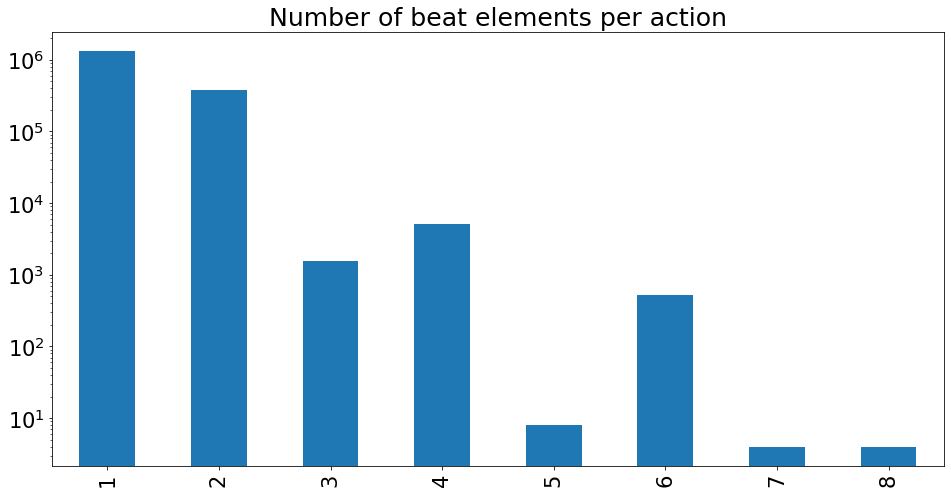

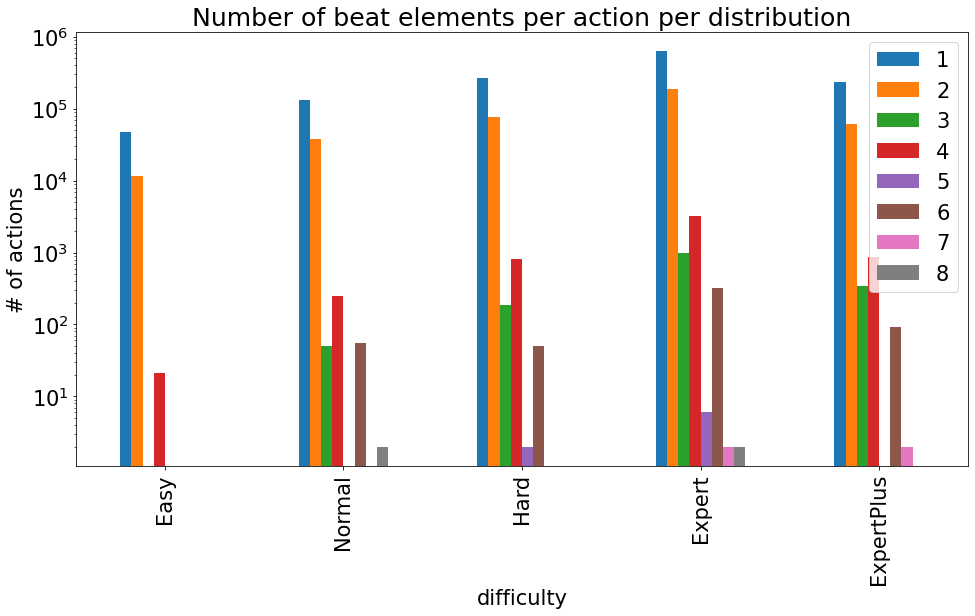

In [36]:
display(Markdown('## Our dataset'))
train, val, test = load_datasets(old_storage_folder)
plot_action_distro(train)

## OxAI dataset

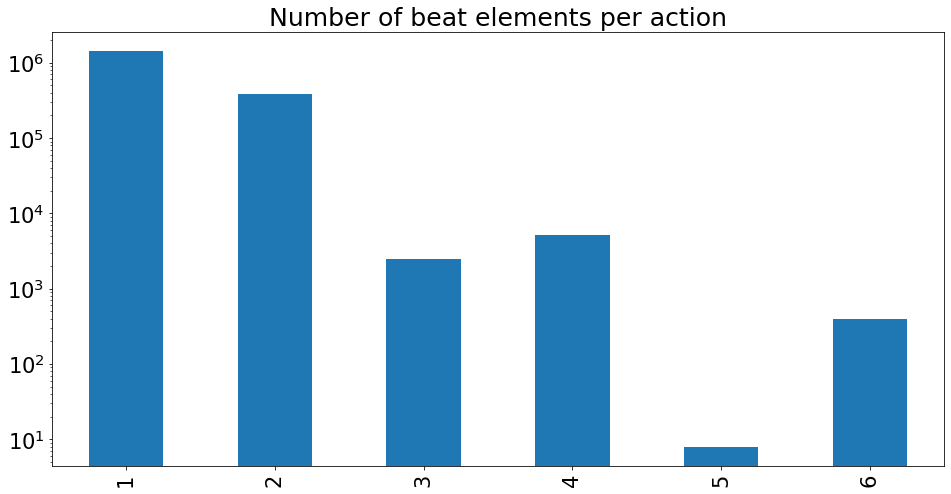

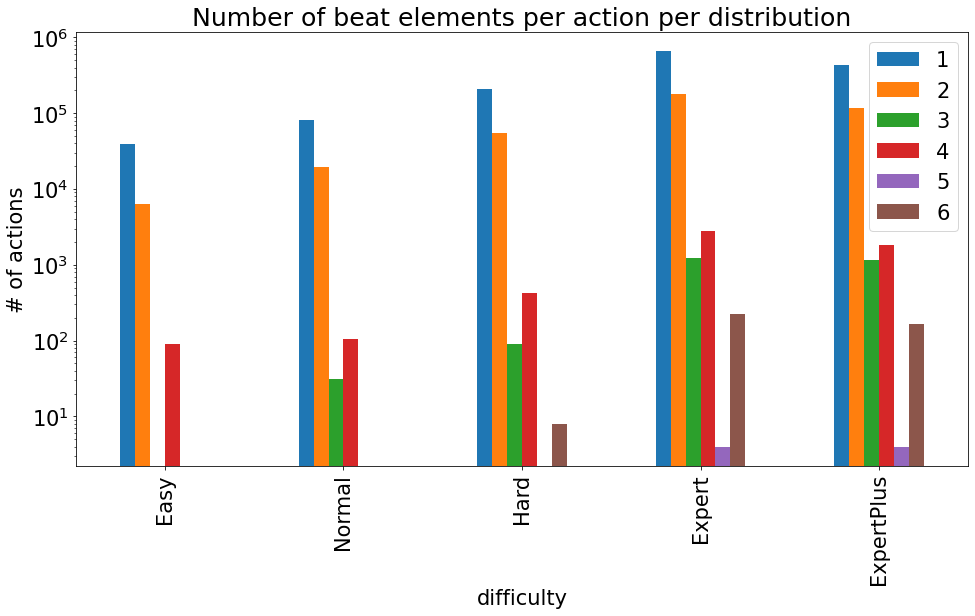

In [37]:
display(Markdown('## OxAI dataset'))
train, val, test = load_datasets(storage_folder)
plot_action_distro(train)

## Song length

In [9]:
def create_sentence(x):
    x.name = 'word'
    x = x.reset_index('time')
    x = x.drop_duplicates('time')
    return x.word.to_list()

def plot_sentence_lengths(df):
    lengths = df.droplevel(2).word.groupby(['name', 'difficulty']).apply(create_sentence).str.len()
    ax = lengths.plot.hist(figsize=(16, 8))
    ax.set_xlabel('Sentence length [# words]')
    display(lengths.describe().to_frame())

## Our dataset

,word
count,1615.000000
mean,512.653251
std,250.657588
min,57.000000
25%,329.500000
50%,469.000000
75%,645.000000
max,1701.000000


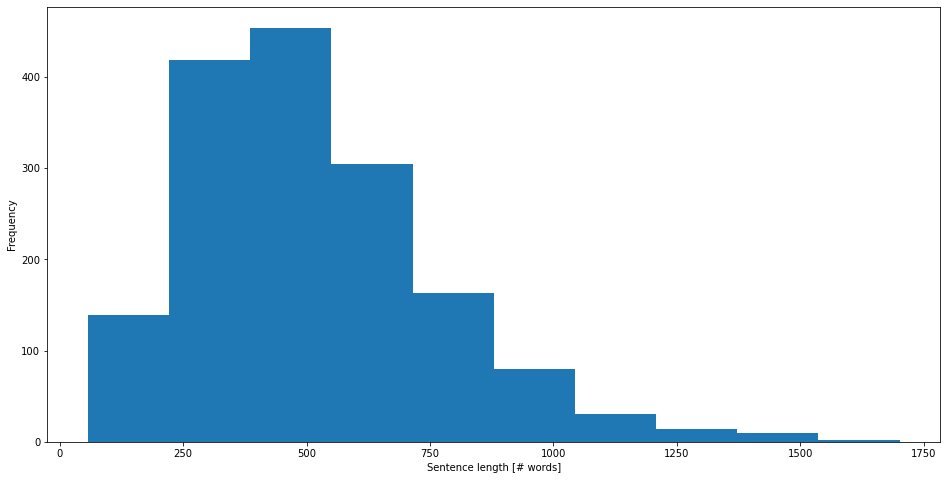

In [10]:
display(Markdown('## Our dataset'))
train, val, test = load_datasets(old_storage_folder)
plot_sentence_lengths(train)

## OxAI dataset

,word
count,1499.000000
mean,590.402268
std,315.588323
min,52.000000
25%,360.000000
50%,548.000000
75%,758.000000
max,3013.000000


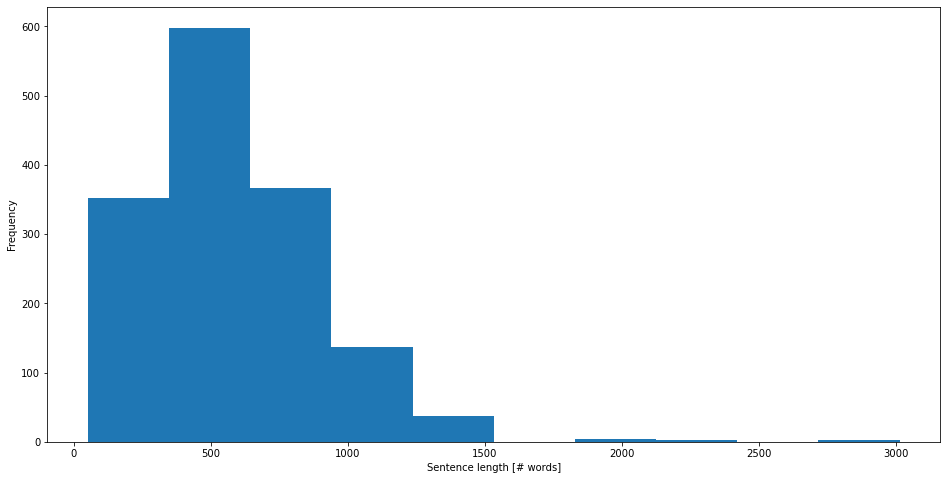

In [11]:
display(Markdown('## OxAI dataset'))
train, val, test = load_datasets(storage_folder)
plot_sentence_lengths(train)

# Action velocity

Given a beat map $B$, action velocity with $\text{window} = w$ at time $t$ is defined as
$$\text{action velocity}_t = \frac {B_{t-2w} + \ldots + B_{t-w-1} - B_{t-w} - \ldots - B_{t-1}} {w}\text{, or}$$

or

```python
def action_velocity(B: DataFrame, w, t) -> float:
    last = B[t - 2 * w:t - w - 1].word_vec
    current = B[t - w:t - 1].word_vec
    return current.mean() - last.mean()
```    


In [12]:
import numpy as np

def get_vec_df(df):
    nodup = df.droplevel(2)
    nodup = nodup.loc[~nodup.index.duplicated()]

    top = 900000 #9000
    return pd.DataFrame(np.array(nodup.word_vec.values.tolist())[:top], index=nodup.index[:top])

train_vec = get_vec_df(train)
val_vec = get_vec_df(val)

In [13]:
from scipy.spatial import distance

def cosine_dist(a, b):
    return 1 - np.sum(a * b, axis=-1)  / (np.linalg.norm(a, axis=-1) * np.linalg.norm(b, axis=-1))

### Action velocity distribution

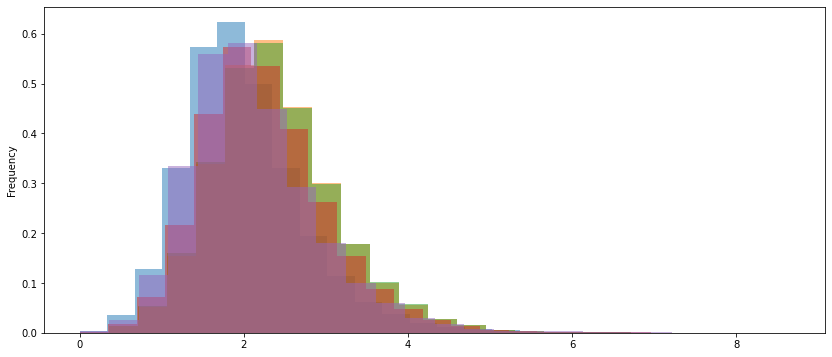

In [14]:
from matplotlib import pyplot as plt 

def compute_velocity(df, window=7):
    means = df.iloc[::].rolling(window, win_type='boxcar').mean(std=7, tau=7, sym=False)

    velocity  = cosine_dist(means.values, means.shift(window).values)
    diff = means - means.shift(window)
    velocity = ((diff.dropna()**2).sum(axis=1))**(1/2)
    return pd.Series(velocity).dropna()

display(Markdown('### Action velocity distribution'))

ax = train_vec.groupby(['name', 'difficulty']).apply(compute_velocity).groupby('difficulty').plot.hist(bins=24, figsize=(14, 6), density=True, alpha=0.5)

In [15]:
train_vel = train_vec.groupby(['name', 'difficulty']).apply(compute_velocity).reset_index(1)
val_vel = val_vec.groupby(['name', 'difficulty']).apply(compute_velocity).reset_index(1)
val_vel.difficulty.unique()

array(['Expert', 'Hard', 'Normal', 'ExpertPlus', 'Easy'], dtype=object)

## Action velocity distribution comparison options

### Kolmogorov-Smirnov statistic on 2 samples
> This tests whether 2 samples are drawn from the same distribution. Note that, like in the case of the one-sample KS test, the distribution is assumed to be continuous.

> If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

[[Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html)]

[[0.03734917 0.16592283 0.15729587 0.13994193]
 [0.08822343 0.0947651  0.10043171 0.07029026]
 [0.17808696 0.07773655 0.06397367 0.04699011]
 [0.17577616 0.0729803  0.05980246 0.04354774]]
[[2.66641324e-03 3.62369231e-57 2.02400144e-51 8.66330947e-41]
 [5.42548049e-17 1.53661813e-19 6.79623007e-22 6.09409395e-11]
 [7.17736965e-69 1.81762138e-13 2.94168875e-09 3.43339739e-05]
 [6.64151772e-67 6.93911370e-12 4.03798586e-08 1.66230056e-04]]


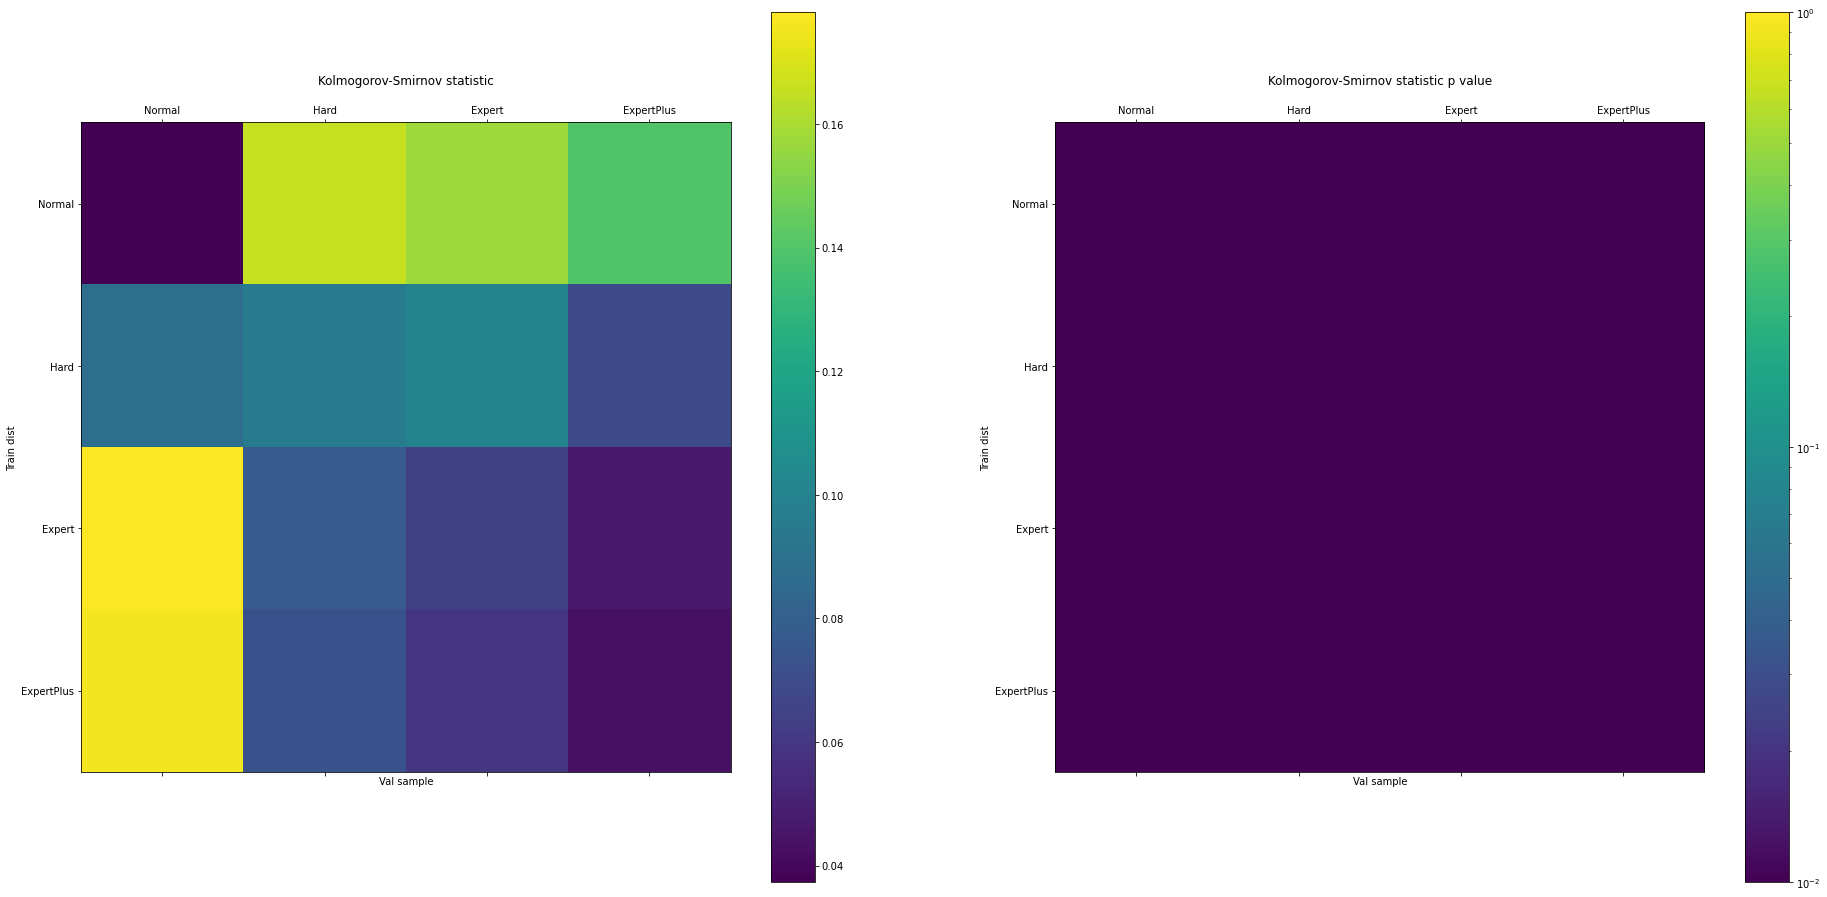

In [16]:
from matplotlib.colors import LogNorm
from scipy.stats import ks_2samp

difficulties = ['Normal', 'Hard', 'Expert', 'ExpertPlus', ]
use_songs = 5

stat = np.zeros((len(difficulties), ) * 2)
pval = np.zeros((len(difficulties), ) * 2)

for i, dif0 in enumerate(difficulties):
    for j, dif1 in enumerate(difficulties):
        if dif0 != dif1 or True:
            stat[i, j], pval[i, j] = ks_2samp(train_vel.loc[train_vel.difficulty == dif0][0][:],
                                            val_vel.loc[val_vel.difficulty == dif1][0][:500 * use_songs])

print(stat)
fig = plt.figure(figsize=(32, 16))
ax = fig.add_subplot(121)
cax = ax.matshow(stat)
plt.title('Kolmogorov-Smirnov statistic')
fig.colorbar(cax)
ax.set_xticklabels([''] + difficulties)
ax.set_yticklabels([''] + difficulties)
plt.ylabel('Train dist')
plt.xlabel('Val sample')
# plt.show()

print(pval)
ax = fig.add_subplot(122)
cax = ax.matshow(pval, norm=LogNorm(vmin=0.01, vmax=1))
# cax = ax.matshow(pval, )   # for non log color
plt.title('Kolmogorov-Smirnov statistic p value')
fig.colorbar(cax)
ax.set_xticklabels([''] + difficulties)
ax.set_yticklabels([''] + difficulties)
plt.ylabel('Train dist')
plt.xlabel('Val sample')
plt.show()

In [17]:
import numpy as np
from scipy.stats import norm
from scipy.special import kl_div
from matplotlib import pyplot as plt
import tensorflow as tf

In [18]:
def kl_divergence(p, q, epsilon=1e-7):
    return np.sum(np.where(p != 0, p * np.log(p / (q + epsilon)), 0))

### AVD for different difficulties

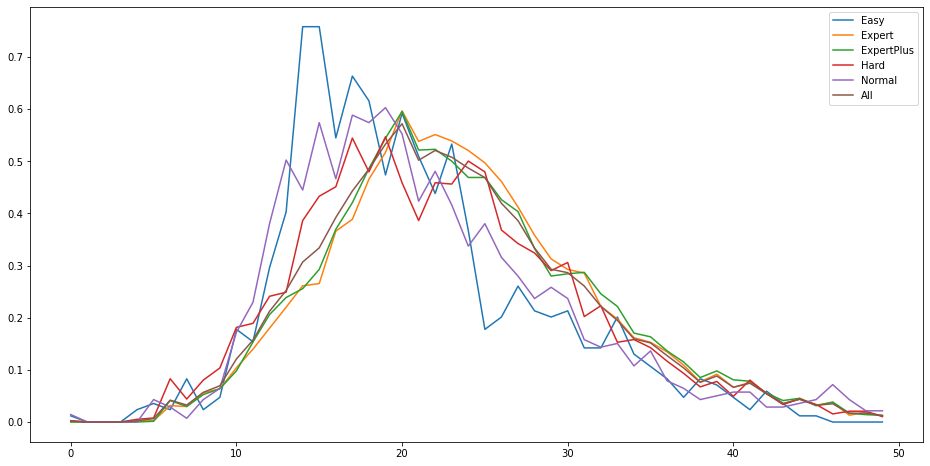

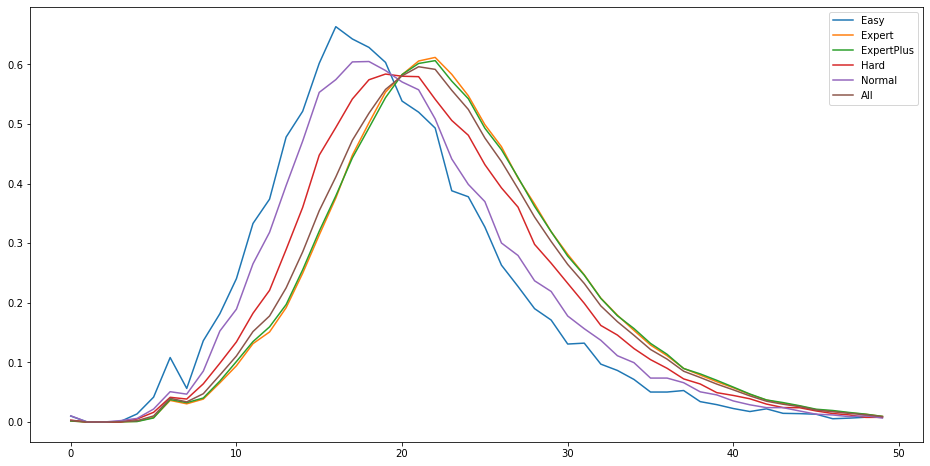

In [20]:
def get_bins(ser):
    hist = np.histogram(ser,
                        density=True,
                        bins=50,
                        range=(0, 5),
                       )
    return hist[0]

use_beatmaps = 50
train_bins = train_vel[0].groupby('difficulty').apply(get_bins)
val_bins = val_vel[0][:500 * use_beatmaps].groupby('difficulty').apply(get_bins)

train_bins = train_bins.append(pd.Series([get_bins(train_vel[0])], index=['All']))
val_bins = val_bins.append(pd.Series([get_bins(val_vel[0][:500 * use_beatmaps])], index=['All']))
ax = pd.DataFrame(val_bins.values.tolist(), index=val_bins.index).T.plot(figsize=(16, 8))
ax = pd.DataFrame(train_bins.values.tolist(), index=train_bins.index).T.plot(figsize=(16, 8))

### Experiment with AVD distance using KL divergence

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


[[0.40339421 0.46585211 1.0154627  1.08587178 0.69703728]
 [0.4354732  0.19436203 0.34064725 0.39994522 0.19380283]
 [0.86168186 0.3336111  0.07594829 0.1455002  0.10074069]
 [0.82701776 0.30664282 0.06744415 0.12484142 0.08490754]
 [0.66991547 0.23245261 0.10892675 0.17415075 0.0772103 ]]


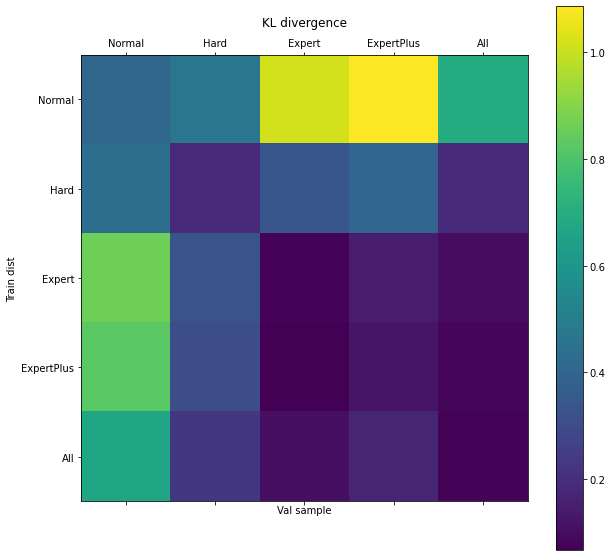

In [22]:
from matplotlib.colors import LogNorm
difficulties = ['Normal', 'Hard', 'Expert', 'ExpertPlus', 'All']

kld = np.zeros((len(difficulties), ) * 2)

for i, dif0 in enumerate(difficulties):
    for j, dif1 in enumerate(difficulties):
        try:
            kld[i, j] = kl_divergence(train_bins[dif0], val_bins[dif1])
        except KeyError:
            pass

print(kld)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(kld)
plt.title('KL divergence')
fig.colorbar(cax)
ax.set_xticklabels([''] + difficulties)
ax.set_yticklabels([''] + difficulties)
plt.xlabel('Val sample')
plt.ylabel('Train dist')
plt.show()

## AVD distance

Given a beat map $B$, action velocity with $\text{window} = w$ at $t$th action is defined as
$$\text{action velocity}_{t, w} = \frac {B_{t-2w} + \ldots + B_{t-w-1} - B_{t-w} - \ldots - B_{t-1}} {w}\text .$$
Action velocity distribution (AVD) of a beat map $B$ is defined as

$$B'_w = \{\text{action velocity}_{t, w} | t \in \mathbb N_0, t < |B|\} \text .$$
AVD of a set of beat maps $S$ is defined as

$$S'_w = \bigcup\limits_{B \in S} B'_w \text .$$

Given two sets of beat maps $F, G$, AVD distance of the first $k$ windows is defined as
$$\text {AVD distance}_k = \frac {\text{KS statistic}( F'_1, G'_1) + \ldots + \text{KS statistic}(F'_k, G'_k)}{k} \text .$$

AVD distance is computed as

```python
def action_velocities(S, window) -> List[float]:
    for B in S:
        for t in range(2 * window, len(B)):
            yield action_velocity(B, window, t)
    
def avd_distance(S0, S1, window) -> float:
    S0_v = action_velocities(S0, window)
    S1_v = action_velocities(S1, window)
    return kolmogorov_smirnov_statistic(S0_v, S1_v)

def avd_distance(S0, S1, k) -> float:
    distances = [avd_distance(S0, S1, w) 
                    for w in range(1, k)]
```

Let's find a fast way to compute it.

In [29]:
from multiprocessing import Pool
from itertools import starmap

def compute_complete_velocity(ser, window):
    return window, ser.groupby(['name', 'difficulty']).apply(lambda ser_: compute_velocity(ser_, window))

def multi_cached_v(df):
    pool = Pool()
    cached_train_v = dict(pool.starmap(compute_complete_velocity, [(df, window) 
                                                                   for window in range(1, 32)]))
#     cached_train_v = dict(starmap(compute_complete_velocity, [(df, window) 
#                                                                    for window in range(1, 32)]))
    pool.close()
    pool.join()
    return cached_train_v


%time multi_cached_train_v = multi_cached_v(train_vec.iloc[:100000])

CPU times: user 1.1 s, sys: 1.7 s, total: 2.79 s
Wall time: 1min 29s


In [31]:
def get_window_v(df, i):
    df /= i
    return i, (((df - df.shift(i)).dropna()**2).sum(axis=1))**(1/2)

def algo_cached_v(df):
    windows_size = 32
    sum_dict = {1: df}
    shifted = df
    for i in range(2, windows_size):
        shifted = shifted.shift(1)
        sum_dict[i] = sum_dict[i-1] + shifted

    params = ((sum_dict[window], window) for window in range(1, windows_size))
    pool = Pool()
    sum_dict = dict(pool.starmap(get_window_v, params))
    pool.close()
    pool.join()
        
#   pure single core
#     for i in range(1, windows):
#         sum_dict[i] /= i
#         sum_dict[i] = (((sum_dict[i] - sum_dict[i].shift(i)).dropna()**2).sum(axis=1))**(1/2)
    return sum_dict


%time algo_cached_train_v = algo_cached_v(train_vec.iloc[:100000])

CPU times: user 12.1 s, sys: 4.68 s, total: 16.7 s
Wall time: 35.8 s


For results see `results_exploration` notebook

In [64]:
%time per_cached_train_v = train_vec.iloc[:100000].groupby(['name', 'difficulty']).apply(algo_cached_v)

CPU times: user 13.4 s, sys: 16.7 ms, total: 13.4 s
Wall time: 13.4 s


In [30]:
train_vec.iloc[:100000].groupby(['name', 'difficulty']).apply(lambda ser_: compute_velocity(ser_, 3))

name  difficulty  name  difficulty  time  
250f  Expert      250f  Expert      22.500    0.999408
                                    22.751    0.908603
                                    22.999    0.930006
                                    23.250    0.991410
                                    23.501    1.004286
                                                ...   
3539  ExpertPlus  3539  ExpertPlus  25.317    1.315136
                                    25.461    1.122963
                                    25.609    0.875245
                                    25.752    0.747014
                                    25.896    0.629000
Length: 89813, dtype: float64

### View results with KL divergence

In [33]:
for window, train_v in multi_cached_train_v.items():
    snippet_v = snippet.apply(lambda df: compute_velocity(df, window))
    stat = kl_divergence(get_bins(train_v), get_bins(snippet_v))
    print(f'{window:4}\t{stat:3.2f}\t|means: {train_v.mean()} {snippet_v.mean()}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


   1	0.16	|means: 6.099479679654118 6.139457242505934
   2	0.11	|means: 4.182157858269476 4.281844148108632
   3	0.07	|means: 3.3650619225221696 3.419716048017931
   4	0.04	|means: 2.8724284604784325 2.92452424140102
   5	0.06	|means: 2.679637880426593 2.7275077344023924
   6	0.06	|means: 2.4849250602515456 2.529180029432043
   7	0.04	|means: 2.331642296778404 2.364016841183875
   8	0.04	|means: 2.196226017247819 2.223384845662084
   9	0.05	|means: 2.113640390274142 2.133210342523591
  10	0.05	|means: 2.0316664849481176 2.04625157660889
  11	0.04	|means: 1.9594230502736496 1.9683274456048403
  12	0.05	|means: 1.8914172855698783 1.896236229277002
  13	0.03	|means: 1.8435620476066343 1.8416941655090933
  14	0.03	|means: 1.7952534307151304 1.788166965339904
  15	0.03	|means: 1.749533231725042 1.7407788855194721
  16	0.04	|means: 1.7072074178258232 1.6960215534818768
  17	0.02	|means: 1.6749632527121945 1.659301340725744
  18	0.02	|means: 1.6425646783472378 1.6239152476294036
  19	0.03	|me